
**Project Repository:** https://github.com/GokulKarthik/deep-learning-projects-pytorch

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [ ]:
cpu_count = mp.cpu_count()
print(cpu_count)

2


## 1. Make train-test split

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"ahsang","key":"91a8a7f7a45e5bafe9a4e8fe70bab854"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gagan2000/khatt-data

 93% 221M/237M [00:01<00:00, 205MB/s]
100% 237M/237M [00:01<00:00, 173MB/s]


In [ ]:
!unzip khatt-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/Images/OnlineKHATT_A0360_2_6.jpg  
  inflating: data/Images/OnlineKHATT_A0360_2_7.jpg  
  inflating: data/Images/OnlineKHATT_A0360_3_1.jpg  
  inflating: data/Images/OnlineKHATT_A0360_3_2.jpg  
  inflating: data/Images/OnlineKHATT_A0360_3_4.jpg  
  inflating: data/Images/OnlineKHATT_A0360_3_5.jpg  
  inflating: data/Images/OnlineKHATT_A0360_3_6.jpg  
  inflating: data/Images/OnlineKHATT_A0360_3_7.jpg  
  inflating: data/Images/OnlineKHATT_A0361_2_1.jpg  
  inflating: data/Images/OnlineKHATT_A0361_2_2.jpg  
  inflating: data/Images/OnlineKHATT_A0361_2_3.jpg  
  inflating: data/Images/OnlineKHATT_A0361_2_4.jpg  
  inflating: data/Images/OnlineKHATT_A0361_2_5.jpg  
  inflating: data/Images/OnlineKHATT_A0361_2_6.jpg  
  inflating: data/Images/OnlineKHATT_A0361_3_1.jpg  
  inflating: data/Images/OnlineKHATT_A0361_3_2.jpg  
  inflating: data/Images/OnlineKHATT_A0361_3_3.jpg  
  inflating: data/Images/OnlineKHATT_A0361_3_4.j

In [ ]:
data_path = "/content/data/Images"

In [ ]:
image_fns = os.listdir(data_path)
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

8498
[21 22 25]


In [ ]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
           print(idx, image_fn)

Streaming output truncated to the last 5000 lines.
3498 OnlineKHATT_A0885_2_5.jpg
3499 OnlineKHATT_A0430_2_5.jpg
3500 OnlineKHATT_A0348_3_6.jpg
3501 OnlineKHATT_A0578_2_3.jpg
3502 OnlineKHATT_A0240_3_5.jpg
3503 OnlineKHATT_A0116_2_7.jpg
3504 OnlineKHATT_A0276_2_2.jpg
3505 OnlineKHATT_A0927_3_6.jpg
3506 OnlineKHATT_A0141_3_1.jpg
3507 OnlineKHATT_A0752_2_6.jpg
3508 OnlineKHATT_A0986_3_5.jpg
3509 OnlineKHATT_A0796_3_4.jpg
3510 OnlineKHATT_A0427_3_4.jpg
3511 OnlineKHATT_A0515_3_3.jpg
3512 OnlineKHATT_A0725_2_2.jpg
3513 OnlineKHATT_A0245_2_5.jpg
3514 OnlineKHATT_A0156_3_4.jpg
3515 OnlineKHATT_A0038_2_5.jpg
3516 OnlineKHATT_A0129_2_7.jpg
3517 OnlineKHATT_A0977_3_1.jpg
3518 OnlineKHATT_A0761_3_2.jpg
3519 OnlineKHATT_A0470_2_5.jpg
3520 OnlineKHATT_A0362_2_5.jpg
3521 OnlineKHATT_A0986_2_4.jpg
3522 OnlineKHATT_A0906_3_4.jpg
3523 OnlineKHATT_A1115_3_2.jpg
3524 OnlineKHATT_A0175_3_6.jpg
3525 OnlineKHATT_A0436_2_3.jpg
3526 OnlineKHATT_A0866_3_2_003.jpg
3527 OnlineKHATT_A0269_3_3.jpg
3528 OnlineKHAT

In [ ]:
image_fns.remove('samples')
print(len(image_fns))

1070


In [ ]:
image_fns_train, image_fns_test = train_test_split(image_fns, random_state=0,test_size=0.1)
print(len(image_fns_train), len(image_fns_test))

7648 850


## 2. Define character maps

In [ ]:
import pandas as pd
df = pd.read_table('/content/data/OnlineKhatt.tsv')
df['text'] = df['text'].astype(str)
image_ns = df['text'].to_list()

letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

8165
['" إن اكرمكم عندالله أتقاكم"', '" الذي يشير إليه في كتابه، كان سجل', '" لهم الملك قديماً كان"، فهي لا ريب', '" ما نصه: تاروت جزيرة في خليج القطيف،', '" مواكبة لمستجدات الحياه المعاصرة منسجمه مع حقيقه', '" و "القطوريين" أي البوادي', '" ويدل عرضه بأسلوبة الأدبى المعروف على أنه', '"، "كان البرد القارس مؤلما، كأنه سهام تخترق', '"آل غسان"، وبقيمة سادات العرب، فورد في شعرهم', '"أبا نصر محمد بن عبد الله اليهري". وقال', '"أبي نصر" و "وهب بن منبه" و "كعب', '"أحمد بن الأغر الشهابي من كندة" و "محمد', '"ابو جعفر النحاس" في أمر "المعلقات": "إن حماداً', '"اعرب" بمعنى "أعراب" و لم يقصد بها قومية،', '"الإكليل تختلف باختلاف النسخ اختلافاً كبيراً', '"الإكليل" ولا كل مؤلفات الهمداني أوغيره من علماء', '"الاكليل" على أن ذلك السجل، هو سجل "محمد', '"البازلت" .دفى حجاره المناجم خامات معادن متعدده، ونوجد', '"البحر" الخليج، وأن لفظة "الجمل" "جملو" " ْكَمَلو"', '"التاريخ الجاهلي"، أو "تأريخ الجاهلية"، وان يذهبوا إِلى', '"الحروف الحميرية". وكان الرأي السائد بادئ بدء إنها', '"الشبكة العميقه"، المتخفية من محر

In [ ]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

8166
['-', '" إن اكرمكم عندالله أتقاكم"', '" الذي يشير إليه في كتابه، كان سجل', '" لهم الملك قديماً كان"، فهي لا ريب', '" ما نصه: تاروت جزيرة في خليج القطيف،', '" مواكبة لمستجدات الحياه المعاصرة منسجمه مع حقيقه', '" و "القطوريين" أي البوادي', '" ويدل عرضه بأسلوبة الأدبى المعروف على أنه', '"، "كان البرد القارس مؤلما، كأنه سهام تخترق', '"آل غسان"، وبقيمة سادات العرب، فورد في شعرهم', '"أبا نصر محمد بن عبد الله اليهري". وقال', '"أبي نصر" و "وهب بن منبه" و "كعب', '"أحمد بن الأغر الشهابي من كندة" و "محمد', '"ابو جعفر النحاس" في أمر "المعلقات": "إن حماداً', '"اعرب" بمعنى "أعراب" و لم يقصد بها قومية،', '"الإكليل تختلف باختلاف النسخ اختلافاً كبيراً', '"الإكليل" ولا كل مؤلفات الهمداني أوغيره من علماء', '"الاكليل" على أن ذلك السجل، هو سجل "محمد', '"البازلت" .دفى حجاره المناجم خامات معادن متعدده، ونوجد', '"البحر" الخليج، وأن لفظة "الجمل" "جملو" " ْكَمَلو"', '"التاريخ الجاهلي"، أو "تأريخ الجاهلية"، وان يذهبوا إِلى', '"الحروف الحميرية". وكان الرأي السائد بادئ بدء إنها', '"الشبكة العميقه"، المتخفية م

## 3. Define data loader

In [ ]:
batch_size = 16

In [ ]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
trainset = CAPTCHADataset(data_path, image_fns_train) 
testset = CAPTCHADataset(data_path, image_fns_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
print(len(train_loader), len(test_loader))

478 54


In [ ]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

RuntimeError: ignored

## 4. Define model

In [ ]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

20


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
resnet = resnet18(pretrained=True)
#print(resnet)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [ ]:
#crnn

In [ ]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('d236n', 'pybee', 'pp87n', '5325m', '7b4bm', 'e46yw', 'n5n8b', 'yxd7m', 'ecd4w', '664nf', 'g247w', '4433m', '6bxwg', 'gcfgp', '3b4we', '6pfy4')
torch.Size([10, 16, 20])


## 5. Define loss

In [ ]:
criterion = nn.CTCLoss(blank=0)

In [ ]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [ ]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [ ]:
compute_loss(text_batch, text_batch_logits)

tensor(4.5563, grad_fn=<MeanBackward0>)

## 6. Train model

In [ ]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [ ]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [ ]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [ ]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:1    Loss:3.0023444072872985    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:2    Loss:2.389148515813491    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:3    Loss:1.9043862913169114    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:4    Loss:1.6125110224181531    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:5    Loss:1.4588318993063534    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:6    Loss:1.3355910965040618    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:7    Loss:1.2477834598690856    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:8    Loss:1.1874341053121231    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:9    Loss:1.137073554244696    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:10    Loss:1.1012410486445707    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:11    Loss:1.093123478047988    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:12    Loss:1.1102593248965693    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:13    Loss:1.051211178302765    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:14    Loss:0.9966630176001904    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:15    Loss:0.944001622059766    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:16    Loss:0.9398863607761907    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:17    Loss:0.8834707433102178    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:18    Loss:0.9086792036598804    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:19    Loss:0.8340057415120742    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:20    Loss:0.7807719426996568    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:21    Loss:0.7829112387170979    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:22    Loss:0.8815145375681859    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:23    Loss:0.8568002336165484    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:24    Loss:0.7624026700562122    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:25    Loss:0.7351289344768898    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:26    Loss:0.726247765269934    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:27    Loss:0.7624815842684578    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:28    Loss:0.7659359609379488    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:29    Loss:0.713158927711786    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:30    Loss:0.7075171634262684    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:31    Loss:0.7374382182663562    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:32    Loss:0.8111970728518916    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:33    Loss:0.7793071258301828    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:34    Loss:0.7550014058748881    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:35    Loss:0.6828262268328199    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:36    Loss:0.6664249090587392    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:37    Loss:0.6663199078802969    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:38    Loss:0.6648452597505906    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:39    Loss:0.6601706871799394    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:40    Loss:0.6874019795773076    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:41    Loss:0.7133267662104439    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:42    Loss:0.8273860052520153    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:43    Loss:0.7890443311018103    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:44    Loss:0.6829198248246137    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:45    Loss:0.6646794139170179    NumUpdates:51
Epoch 00045: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:46    Loss:0.6076396306355795    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:47    Loss:0.5849831501642863    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:48    Loss:0.577365960560593    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:49    Loss:0.57144094915951    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:50    Loss:0.5668661500893387    NumUpdates:51


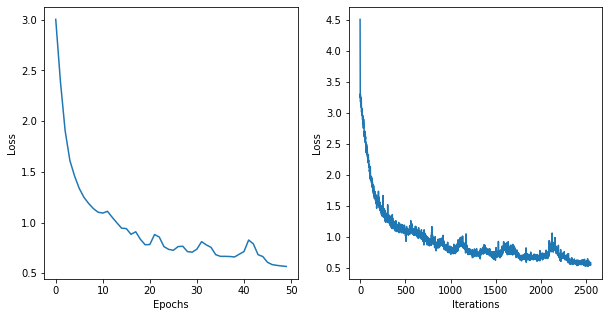

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## 7. Make predictions

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
print(results_train.shape)
results_train.head()

(802, 2)


,actual,prediction
0,6n6gg,66nn66gggg
1,ddcne,dd-dccnnee
2,mgw3n,mmggww33nn
3,4ycex,44yycceexx
4,x6b5m,xx66bb55mm


In [ ]:
print(results_test.shape)
results_test.head()

(268, 2)


,actual,prediction
0,w4cdc,ww44cccccc
1,n4xx5,nn44xxxx55
2,e76n4,ee7766nn44
3,ddcdd,ddddccdddd
4,bbymy,bbbbyymmyy


In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,6n6gg,66nn66gggg,6n6g
1,ddcne,dd-dccnnee,ddcne
2,mgw3n,mmggww33nn,mgw3n
3,4ycex,44yycceexx,4ycex
4,x6b5m,xx66bb55mm,x6b5m


In [ ]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,w4cdc,ww44cccccc,w4c
1,n4xx5,nn44xxxx55,n4x5
2,e76n4,ee7766nn44,e76n4
3,ddcdd,ddddccdddd,dcd
4,bbymy,bbbbyymmyy,bymy


## 8. Evaluate the model

In [ ]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
0,w4cdc,ww44cccccc,w4c
1,n4xx5,nn44xxxx55,n4x5
3,ddcdd,ddddccdddd,dcd
4,bbymy,bbbbyymmyy,bymy
7,yyg5g,yyyygg55gg,yg5g
25,mx8bb,mmxx88bbbb,mx8b
28,pgg3n,ppgggg33nn,pg3n
37,pcmcc,ppccmmcccc,pcmc
42,d4ppy,dd44ppppyy,d4py
47,85622,8855662222,8562


In [ ]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

4    40
3     3
Name: prediction_corrected, dtype: int64


In [ ]:
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected


In [ ]:
mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

IndexError: ignored

In [ ]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)